*Final project assignment for Machine Learning (Math M156) UCLA by Amit Rand and Jonathon Kim.* 

# Import Libraries, Functions, and Data

Include all necessary imports related to data preprocessing and exploratory data anaylsis.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

Load in the data containing clinical information pertaining to Cancer downloaded from Kaggle. Once the data has been read in, display the shape and the first/last rows to get a general hollistic idea of the data. Split the data into X (user data -features) and y (diagnosis - targets.) 

In [2]:
# Load Data 
data = pd.read_csv('CancerData.csv')

# Print data shape and display data to confirm that it's properly loaded
print(data.shape)
display(data)

# Divide columns into user data (x) and diagnosis (y)
X = data.iloc[:, :8]
y = data.iloc[:, 8:]

(1500, 9)


,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis
0,58,1,16.085313,0,1,8.146251,4.148219,1,1
1,71,0,30.828784,0,1,9.361630,3.519683,0,0
2,48,1,38.785084,0,2,5.135179,4.728368,0,1
3,34,0,30.040296,0,0,9.502792,2.044636,0,0
4,62,1,35.479721,0,0,5.356890,3.309849,0,1
...,...,...,...,...,...,...,...,...,...
1495,62,1,25.090025,0,0,9.892167,1.284158,0,1
1496,31,0,33.447125,0,1,1.668297,2.280636,1,1
1497,63,1,32.613861,1,1,0.466848,0.150101,0,1
1498,55,0,25.568216,0,0,7.795317,1.986138,1,1


# Data Cleaning

In order to ensure a high level of preformance from our model, we need to ensure that the data is cleaned and preprocessed accordingly. First and foremost, that means removing any duplicate samples in the dataset that can potentially skew the data. Duplicates can introduce bias into the model, as it could favor repeated samples leading to overfitting. Repeated data can also skew metrics such as accuracy and validation scores, misleading us to the actual preformance of the model. Therefore, we define a function to remove duplicates.

In [3]:
def remove_duplicates(data):
    """
    Removes duplicate rows/samples from a dataset.

    Parameters:
    data: Dataframe to be parsed.

    Returns:
    Dataframe after it was cleaned.
    """
    initial_shape = data.shape
    data = data.drop_duplicates() # remove duplicates
    final_shape = data.shape
    # Compare initial/final shape to determine if duplicates exist
    if initial_shape[0] - final_shape[0] == 0:
        print ("No duplicates in dataset")
    else:
        print(f"Removed {initial_shape[0] - final_shape[0]} duplicate rows.")
    return data

# Remove duplicates from the data
data = remove_duplicates(data)

No duplicates in dataset


The next step in our data prerpocessing is to remove non-numeric values and NaNs. First and foremost, these values must be removed as ML models expect numerical inputs. This will help prevent any errors during the actual computation that occurs with the models and will overall help improve the quality of our data. Below we define and call a function that checks for these non-numeric values in the data and signals out their specific location so they can be handled accordingly.

In [4]:
def check_for_num(data):
    """
    Checks for non-numeric values or NaNs in the data

    Parameters:
    data: Dataframe to be parsed.

    Returns:
    errors: List of strings with the row, and column of the non-numeric values locations in the data frame.
    """
    # Get number of rows/cols
    num_columns = data.shape[1]
    num_rows = data.shape[0]
    errors = []
    # Iterate through the data frame to check each respective cell
    for i in range(num_columns):
        for j in range(num_rows):
            cell_value = data.iloc[j, i]
            # check if not numeric / NaN
            if not pd.api.types.is_numeric_dtype(type(cell_value)) or pd.isna(cell_value):
                errors.append(f"Non-numeric value '{cell_value}' found at row {j}, column {i}")
    return errors

# If all entries are numbers, return an empty list. Otherwise return a list of error statements including their locations
if (len(check_for_num(data)) == 0):
    print("All entries are valid")
else:
    for error in check_for_num(data):
        print(error)

All entries are valid


Finally, we look to find any otulier values in the data in order to ensure a enhanced model preformance. Outliers can skew values in the data such as mean and variance drastically, which can affect the model's ability to learn and recognize patterns. Many models are super sensitive to outliers. By calculating the z-score and removing those above a set threshold, we can remove any data point that deviates drastically from the mean. This helps ensure that a certain data quality standard is met preventing outliers. Below we define a function that does this and identify, and remove any outliers. 

In [5]:
def detect_outliers(data, threshold):
    """
    Detects and replaces any outliers in the data with a NaN on the basis of the calculated Z-scores.

    Parameters:
    data: Dataframe to be parsed.

    Returns:
    data_outliers: Dataframe with the outliers replaced by NaN.
    """
    # Make a copy of the data frame 
    data_outliers = data.copy()

    # Calculate the Z-scores for the entire dataset
    z_scores = np.abs(zscore(data))
    
    # Replace outliers with NaN
    data_outliers = data.mask(z_scores > threshold, np.nan)

    return data_outliers

# Apply outlier detection to the dataset
data = detect_outliers(data, threshold = 3)

if len(check_for_num(data)) == 0:
    print("No outliers detected in the dataset")
else:
    print("Outliers detected in the dataset:")

No outliers detected in the dataset


As our next step, we wanted to explore the data more in depth. Our goal is to understand the relationship between various features and to ensure that some relationship exists. Otherwise, if no relationship exists it should be removed as it is irrelevant data. Before starting this process, we ensure that the data is standardized to further normalize it, as it treats all the features on a comparabale scale. The approach we took to analyze relationships between features is to create 8 suplots, one for each feature, and to visualize the realtionship between each feature and our target (cancer diagnosis.) Each subplot has a scatter plot of the feature values versus the target variable. We also added a logistic regression curve that models the probablity of cancer diagnosis as a function of each respective feature. This helps make it more obvious that an existing relationship exists between a feature and a target.

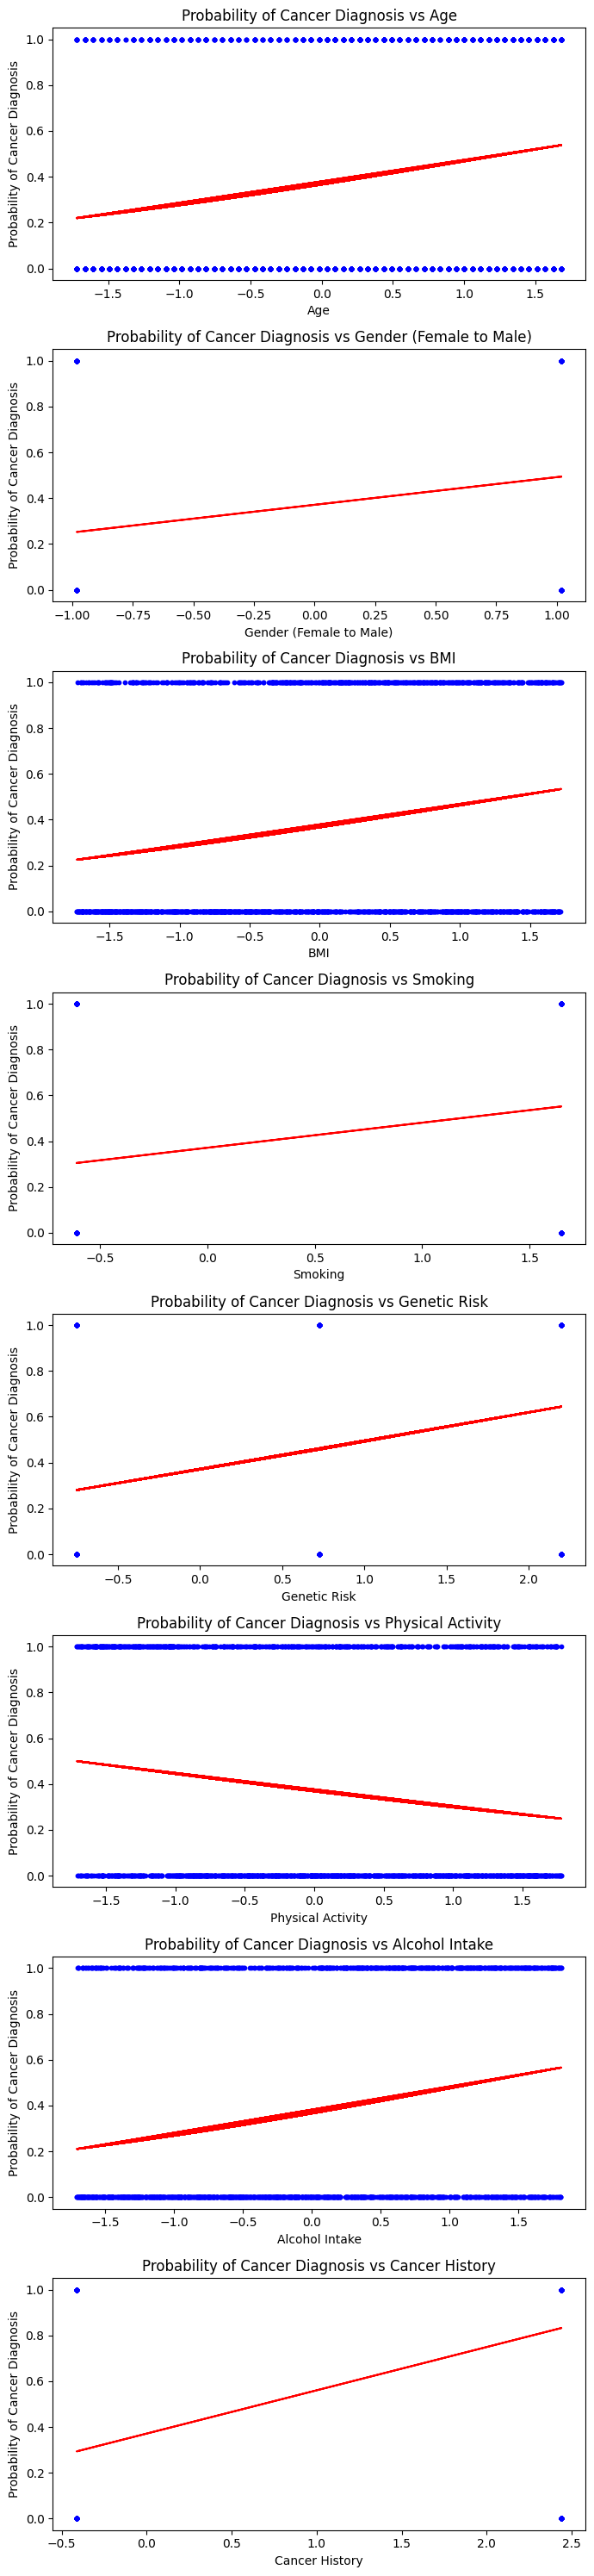

In [6]:
# Standardize the features 
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Create 8 subplots for each feature vs output graph
fig, ax = plt.subplots(nrows = X.shape[1], ncols = 1, figsize = (7, 30))
features = ["Age", "Gender (Female to Male)", "BMI", "Smoking", "Genetic Risk", "Physical Activity", "Alcohol Intake", "Cancer History"]

def graph_logistic_relationships(X, y):    
    """
    Plots logistic regression relationship between each feature in X and target variable y.

    Parameters:
    X: Dataframe (feature matrix)
    y: Dataframe (target vector)

    Returns:
    None
    """
    # Flatten values if necessary
    y_vals = y.values.ravel()

    # Loop through each feature col in X
    for i in range(X.shape[1]):
        x = X[:, i].reshape((-1, 1))  
        
        # Create Scatterplot of points
        ax[i].scatter(x, y_vals, color='blue', s=10)
        
        # Create and plot logistic regression model
        model = LogisticRegression(max_iter = 1000)
        model.fit(x, y_vals)
        y_pred_prob = model.predict_proba(x)[:,1]
        ax[i].plot(x, y_pred_prob, color='red')
        
        # Title and Label plots
        ax[i].set_title(f'Probability of Cancer Diagnosis vs {features[i]}')
        ax[i].set_xlabel(features[i])
        ax[i].set_ylabel('Probability of Cancer Diagnosis')
    
    plt.tight_layout()
    
    plt.show()

# Call graph_logistic_relationships 
graph_logistic_relationships(X,y)

Based on the 8 plots above, it is obvious to tell that there exists some distinctive relationship between the feature and the target. This tells us that all the data we have is relevant to our model and that it should all be kept.

# Comparing Multiple Models 

We were recommended to compare some other models then our intended neural network in our Project Proposal by the Professor, so for our next step we utilized 8 common classifiers and investigated their respective preformances. We started by splitting the data up into training and testing X/y data sets, and standardized the features. 

In [7]:
# Create training and test sets
y = y.values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Standardize the features 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Once our data was ready, we looped through each one of the models and fit the training data to them. After each model was trained on the training data, we tested their ability to predict the target on the test features. Finally, we calculated their accuracy score.

In [8]:
# List of models and respective initializations
models = [
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Support Vector Machines', SVC(random_state = 42)),
    ('K-Nearest Neighbors', KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree', leaf_size=30, p=1, metric='manhattan')),
    ('Decision Tree', DecisionTreeClassifier(max_depth=17, random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=10)),
    ('GaussianNB', GaussianNB()),
    ('LogisticRegression', LogisticRegression(max_iter = 10000, random_state = 42))
]

results = {}
for name, model in models:
    # Fit the model on the training data
    model.fit(X_train, y_train)
    # Predict the labels for test data
    y_pred = model.predict(X_test)
    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {'Acc': accuracy}

# Sort and display the models by accuracy performance
sorted_results = sorted(results.items(), key=lambda x: x[1]['Acc'], reverse=True)
print("Model                        Accuracy")
print("=======================================")
j = 0
for result in sorted_results:
    print(f"{result[0].ljust(25)}{round(float(result[1]['Acc']), 2).__str__().rjust(10)}")

Model                        Accuracy
Random Forest                  0.92
Gradient Boosting              0.91
K-Nearest Neighbors            0.89
Support Vector Machines        0.88
Decision Tree                  0.88
LogisticRegression             0.86
GaussianNB                     0.84


On the basis of these models, we saw that Random Forest scored the highest of all the classifiers with 92% accuracy. As a close second, Gradient Boosting scored 91%. Both of these models are comparatively complex, which is a good sign as a Neural Network is also a comparatively complex model. All three methods can capture non-linear relationships between features and target variables. This also makes sense since comparatively, Logistic regression, a linearly based model scored much lower than GB and random forest at only 86%. Therefore, this established a baseline performance we wanted to aim for our Neural Network to surpass, which was at least 92%. 

# Model Training (Binary Classification Neural Network)

Inlcude all imports relevant to neural network development, training, and evaluation. 

In [9]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

We split the data into training and testing X/y datasets and then convert the data to tensors. The data must be converted into tensors in order to use PyTorch accordingly. 

In [10]:
# Split data into X, y training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Convert data to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1,1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1,1)

*In order to organize our code below, we defined helper functions that we saw were constantly repeated. The three functions we defined are print_architecture, train_model, and evaluate_model. As their names imply, they are used to help us print out the model's architecture, and respectively train and evaluate models that are passed in.*

In [11]:
def train_model(model, optimizer, train_loader, num_epochs):
    """
    Helper function to train the given model.

    Parameters:
    model: Neural network to be trained
    optimizer: Optimizer to be used in training
    train_loader: Dataloder with the batches of training data
    num_epochs: Number of epochs to train the model
    """
    model.train()
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad() # clear and previous gradients
            outputs = model(batch_X) # forward pass
            loss = nn.MSELoss()(outputs, batch_y) # calculate loss
            loss.backward() # backward pass
            optimizer.step() # update model params

In [12]:
def evaluate_model(model, X_test, y_test):
    """
    Helper function to evaluate the performance of the model on the test dataset.

    Parameters:
    model: Trained neural network to be evaluated
    X_test: Test input data
    y_test: Labels for the test data

    Returns:
    float: Accuracy score of the model on the test dataset
    """
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test) # forward pass
        predicted = (test_outputs > 0.5).float() # convert to binary classification
        return accuracy_score(y_test, predicted)

In [13]:
def print_architecture(model_info):
    """
    Helper methods that prints the architecture and hyperparameters of a model.
    
    Parameters:
    model_info: Dict with model, accuracy, and hyperparameters.
        model: The trained model
        accuracy: Accuracy of the model
        params: A dict of hyperparameters:
            width: List of layer widths
            depth: Depth of model
            epochs: Number of epochs
            optimizer: Name of optimizer
            activation_fn: Name of activation function
            batch_size: Batch size
    
    Returns:
    None
    """
    params = model_info['params']
    accuracy = model_info['accuracy']
    print(f"Model Architecture: Accuracy: {accuracy:.4f}, Width {params['width']},  Depth: {params['depth']}, Epochs: {params['epochs']}, Optimizer: {params['optimizer']}, Activation Function: {params['activation_fn']}, Batch Size: {params['batch_size']}")

### First Iteration
Initially, we built out a neural network with three hidden layers 180, 120, and 60 neurons respectively. Each layer included a ReLU activation function while the output layer had a sigmoid activation function. Since we are working on a binary classification problem, it makes sense to use a sigmoid activation function due to its binary nature. We used Binary cross-entropy loss and the ADAM optimizer with a learning rate of 0.01 as starting hyperparameters for our initial model. The model ran for 100 epochs and scored on average an accuracy of around 87%. Unfortunately, it fell short of our initial expectations. 

In [14]:
class Model_1(nn.Module):
    """
    Simple feedforward neural network model with three hidden layers and ReLU activation functions.
    """
    def __init__(self):
        """
        Initialize layers and activation functions for model.
        """
        super(Model_1, self).__init__()
        self.layer1 = nn.Linear(8,180) # first hidden layer
        self.act1 = nn.ReLU() # activation function after h1
        self.layer2 = nn.Linear(180,120) #second hidden layer
        self.act2 = nn.ReLU() # activation function after h2
        self.layer3 = nn.Linear(120,60) # third hidden layer
        self.act3 = nn.ReLU() # activation function after h3
        self.output = nn.Linear(60,1) #output layer
         # sigmoid activtion function to convert to binary classification
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        """
        Forward pass for the network.

        Parmaeters:
        x: Input tensor

        Returns:
        x: Output tensor after passing through all layers/activation functions.
        """
        x = self.act1(self.layer1(x)) # h1 + ReLU
        x = self.act2(self.layer2(x)) # h2 + ReLU
        x = self.act3(self.layer3(x)) # h3 + ReLU
        x = self.sigmoid(self.output(x)) # output + sigmoid
        return x

In [15]:
# Initialize model
model = Model_1()

# Hyperparameters
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100

# training loop
for i in range(num_epochs):
    model.train()
    outputs = model(X_train) # forward pass
    loss = loss_fn(outputs, y_train) # calculate loss

    optimizer.zero_grad() # clear gradients
    loss.backward() # backward pass
    optimizer.step() # update model params

    # print loss every 10 epochs
    if i % 10 == 0:
        print(f'Epoch [{i}/{num_epochs}], Loss: {loss.item():.4f}')
        
# Validate the model
accuracy = evaluate_model(model, X_test, y_test)
print(f'Validation accuracy: {accuracy:.4f}')

Epoch [0/100], Loss: 0.6785
Epoch [10/100], Loss: 0.3418
Epoch [20/100], Loss: 0.2747
Epoch [30/100], Loss: 0.2345
Epoch [40/100], Loss: 0.1996
Epoch [50/100], Loss: 0.1620
Epoch [60/100], Loss: 0.1175
Epoch [70/100], Loss: 0.0828
Epoch [80/100], Loss: 0.0530
Epoch [90/100], Loss: 0.0296
Validation accuracy: 0.8700


### Optimization
In order to improve the accuracy and overall performance of our model, we planned to fine-tune our neural network. To do this, we planned to iterate through multiple sets of hyperparameters to find the best combination of the various permutations. In order to make this possible, we had to define a custom neural network class that is able to take in a customizable architecture of inputs ranging from width and depth to activation functions. We kept the same general outline as our first iteration of the general structure of the neural network. 

In [16]:
class CustomModel(nn.Module):
    """
    Custom neural network model with a customizable architecture. Consists of multiple fully connected linear layers with an activation function between them, followed by an output layer and a sigmoid activation function.

    Parameters:
    layers_widths: List of integers specifying the number of neurons per layer.
    activation_fn: The activation function to be called after each layer.
    """
    def __init__(self, layers_widths, activation_fn):
        """
        Initializes the CustomModel with the provided architecture.

        Parameters:
        layers_widths: List of integers specifying the number of neurons per layer.
        activation_fn: The activation function to be called after each layer.

        Returns:
        None
        """
        super(CustomModel, self).__init__()
        self.layers = nn.ModuleList() # list to hold layers of model
        self.activation_fn = activation_fn
        # Initial input dimension
        input_dim = 8
        # Create hidden layers
        for width in layers_widths:
            # Linear layer
            self.layers.append(nn.Linear(input_dim, width))
            # Activation function
            self.layers.append(activation_fn())
            # Update the dimension for the next layer
            input_dim = width
        self.output = nn.Linear(input_dim, 1) # Output layer
        # Activation function for binary classification
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        """
        Forward pass for the network.

        Parmaeters:
        x: Input tensor

        Returns:
        x: Output tensor after passing through all layers/activation functions.
        """
        for layer in self.layers:
            x = layer(x)
        x = self.sigmoid(self.output(x))
        return x

In order to find the best-performing models now that we have a customizable class, we ran a loop through all the parameters, constructing a model for every single permutation possible. The hyperparameters that we began fine-tuning were the width, depth, epochs, loss functions, learning rates, optimizers, activation functions, and batch sizes. Based on this, we were able to find the best-performing models that had the highest accuracy scores.

Initially, this code was built only to return the best model. However, we realized that the model would return different architectures that performed slightly better with each iteration. This led us to realize two things. First, we should be finalizing the best model based on multiple iterations averaged out. Second, it made us realize how computationally heavy fine-tuning many hyperparameters can be. Initially, this block of code took 2-4 hours to run.

To optimize our work and ensure that our best model was indeed the best, we altered the code to collect the top 5 best-performing model architectures. The goal was to take these top 5 models and later run them each multiple times to average their performance and determine the true best-performing model. Running multiple trainings of every single permutation of hyperparameters would have taken hours and been computationally expensive, leading us to specifically collect 5 models. Additionally, to reduce the time necessary to run our fine-tuning, we removed the hyperparameters for learning rate and loss functions.

Regarding the learning rate, we observed that 0.01 performed better than 0.001 consistently, making it redundant to include it in this block of code. We removed the loss function as we similarly found that the Mean Squared Error (MSE - L2) loss function consistently performed better than both Binary Cross-Entropy and Mean Absolute Error (MAE - L1).

To provide some context for the output below, each model prints its unique architecture, the parameters it includes, and its accuracy. If the model is the best performing one encountered, the code will indicate that it is the current best model.

In [17]:
# Hyperparameter lists
widths = [[120], [180, 120, 60], [256, 128, 64], [64]]
depths = [1,2,3]
epochs = [25, 50, 100, 150]
optimizers = [optim.Adam, optim.RMSprop]
activation_functions = [nn.Tanh, nn.Sigmoid]
batch_sizes = [16, 32]

# mappings for activation functions/optimizers  
activation_fn_map = {
    'Tanh': nn.Tanh,
    'Sigmoid': nn.Sigmoid
}

optimizer_map = {
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop
}

# store the best-performing model
best_params = {}
best_accuracy = 0
best_model = None

# store top 5 models
top_models = []

# Loop that iterates through all permutations of hyperparameters
for width in widths:
    for depth in depths:
        for num_epochs in epochs:
            for opt in optimizers:
                for act_fn_name, act_fn in activation_fn_map.items():
                    for batch_size in batch_sizes:
                        # Initialize model with current hyperparameters
                        model = CustomModel(width[:depth], act_fn)
                        optimizer = opt(model.parameters(), lr=0.01)
                        
                        # Create a dataloader for training with the current batch size
                        train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
                        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                            
                        # Train the model
                        train_model(model, optimizer, train_loader, num_epochs)
                        
                        # Validate the model
                        accuracy = evaluate_model(model, X_test, y_test)
                        print(f'{width[:depth]} {num_epochs} {opt.__name__} {act_fn_name} {batch_size} accuracy on the test set: {accuracy:.4f}')
                            
                        # Manage top 5 models
                        model_params = {
                            'model': model,
                            'accuracy': accuracy,
                            'params': {
                                'width': width[:depth],
                                'depth': depth,
                                'epochs': num_epochs,
                                'optimizer': opt.__name__,
                                'activation_fn': act_fn_name,
                                'batch_size': batch_size
                            }
                        }
                        # If there are less than 5 models currently stored
                        if len(top_models) < 5:
                            # Add model and sort top 5
                            top_models.append(model_params)
                            top_models.sort(key=lambda x: x['accuracy'], reverse=True)
                        else:
                            # If current model has better accuracy than worst model in top 5
                            if accuracy > top_models[-1]['accuracy']:
                                # Remove worse model
                                top_models.pop()
                                # Add new model and sort top 5
                                top_models.append(model_params)
                                top_models.sort(key=lambda x: x['accuracy'], reverse=True)
                    
                        # Update best model info
                        if accuracy > best_accuracy:
                            best_model = model
                            best_accuracy = accuracy
                            best_params = model_params
                            print("New best model:")
                            print_architecture(best_params)

print("Best model architecture:", best_model)
print(f"Best parameters: {best_params}")

[120] 25 Adam Tanh 16 accuracy on the test set: 0.9267
New best model:
Model Architecture: Accuracy: 0.9267, Width [120],  Depth: 1, Epochs: 25, Optimizer: Adam, Activation Function: Tanh, Batch Size: 16
[120] 25 Adam Tanh 32 accuracy on the test set: 0.9033
[120] 25 Adam Sigmoid 16 accuracy on the test set: 0.9067
[120] 25 Adam Sigmoid 32 accuracy on the test set: 0.8867
[120] 25 RMSprop Tanh 16 accuracy on the test set: 0.8967
[120] 25 RMSprop Tanh 32 accuracy on the test set: 0.9133
[120] 25 RMSprop Sigmoid 16 accuracy on the test set: 0.8733
[120] 25 RMSprop Sigmoid 32 accuracy on the test set: 0.8867
[120] 50 Adam Tanh 16 accuracy on the test set: 0.9267
[120] 50 Adam Tanh 32 accuracy on the test set: 0.9100
[120] 50 Adam Sigmoid 16 accuracy on the test set: 0.9033
[120] 50 Adam Sigmoid 32 accuracy on the test set: 0.9133
[120] 50 RMSprop Tanh 16 accuracy on the test set: 0.9100
[120] 50 RMSprop Tanh 32 accuracy on the test set: 0.9200
[120] 50 RMSprop Sigmoid 16 accuracy on the t

On the basis of running this fine-tuning multiple times, we were able to observe the following:
- The highest performance we saw of all the models was at 94.3% accuracy from the following architecture: Accuracy: 0.9433, Width [120],  Depth: 3, Epochs: 25, Optimizer: Adam, Activation Function: Tanh, Batch Size: 16
- We are able to consistently attain an accuracy of 93.3%-94% from at least one model, usually more.
- The sigmoid activation functions tend to perform better than the tanh activation function.
- Models of depths 1-2 perform better than models of depth 3.
- Batch sizes of 16 are consistently better than batch sizes of 32.

In [18]:
# Display the top 5 best-performing models
print(top_models)

[{'model': CustomModel(
  (layers): ModuleList(
    (0): Linear(in_features=8, out_features=120, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=120, out_features=1, bias=True)
  (sigmoid): Sigmoid()
), 'accuracy': 0.9366666666666666, 'params': {'width': [120], 'depth': 2, 'epochs': 100, 'optimizer': 'Adam', 'activation_fn': 'Sigmoid', 'batch_size': 16}}, {'model': CustomModel(
  (layers): ModuleList(
    (0): Linear(in_features=8, out_features=180, bias=True)
    (1): Tanh()
  )
  (output): Linear(in_features=180, out_features=1, bias=True)
  (sigmoid): Sigmoid()
), 'accuracy': 0.9366666666666666, 'params': {'width': [180], 'depth': 1, 'epochs': 50, 'optimizer': 'Adam', 'activation_fn': 'Tanh', 'batch_size': 16}}, {'model': CustomModel(
  (layers): ModuleList(
    (0): Linear(in_features=8, out_features=180, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=180, out_features=1, bias=True)
  (sigmoid): Sigmoid()
), 'accuracy': 0.9366666666666666, 'params

### Final Iteration
Now that we have identified the top 5 best-performing models, we can proceed to finding the final best model. For these top models, we will train each one repeatedly 10 times and average their performance. This approach will help ensure that we identify the most consistently best-performing model and verify that its performance is not just a fluke.

*It is important to note that the model's average performance may be relatively lower than its individual performances because a single outlier can have a significant impact on the mean. Therefore, we also consider the standard deviation and the median of the models' performances. The median provides a more accurate representation of the model's performance in the presence of outliers, while the standard deviation offers insights into the model's consistency and variance.*

In [24]:
# Store top 5 models as only their parameters in `top_models`
best_avg_acc = 0
best_avg_params = {}
for index, model_params in enumerate(top_models):
    params = model_params['params']
    accuracies = []
    for _ in range(10):  # Run each model 10 times
        # Reinitialize model with the best parameters
        activation_fn_instance = activation_fn_map[params['activation_fn']]
        optimizer_class = optimizer_map[params['optimizer']]
        model = CustomModel(params['width'], activation_fn_instance)
        optimizer = optimizer_class(model.parameters(), lr=0.01)
        
        train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
        
        # Train the model
        train_model(model, optimizer, train_loader, params['epochs'])
        
        # Evaluate the model
        accuracy = evaluate_model(model, X_test, y_test)
        accuracies.append(accuracy)
            
    average_accuracy = np.mean(accuracies)
    std_dev_accuracy = np.std(accuracies)
    median_accuracy = np.median(accuracies)
    
    if best_avg_acc < average_accuracy:
        best_avg_acc = average_accuracy
        best_model = model
        best_avg_params = {
            'model': model,
            'accuracy': average_accuracy,
            'params': {
                'width': params['width'],
                'depth': params['depth'],
                'epochs': params['epochs'],
                'optimizer': params['optimizer'],
                'activation_fn': params['activation_fn'],
                'batch_size': params['batch_size']
            }
        }
        
    print(f"Model {index+1} (width: {params['width']}, depth: {params['depth']}, epochs: {params['epochs']}, optimizer: {params['optimizer']}, activation function: {params['activation_fn']}, batch size: {params['batch_size']})")
    print(f"\tAverage accuracy over 10 runs: {average_accuracy:.4f}")
    print(f"\tStandard deviation of accuracy: {std_dev_accuracy:.4f}")
    print(f"\tMedian accuracy over 10 runs: {median_accuracy:.4f}")

Model 1 (width: [120], depth: 2, epochs: 100, optimizer: Adam, activation function: Sigmoid, batch size: 16)
	Average accuracy over 10 runs: 0.9223
	Standard deviation of accuracy: 0.0050
	Median accuracy over 10 runs: 0.9217
Model 2 (width: [180], depth: 1, epochs: 50, optimizer: Adam, activation function: Tanh, batch size: 16)
	Average accuracy over 10 runs: 0.9117
	Standard deviation of accuracy: 0.0062
	Median accuracy over 10 runs: 0.9117
Model 3 (width: [180], depth: 1, epochs: 100, optimizer: RMSprop, activation function: Sigmoid, batch size: 16)
	Average accuracy over 10 runs: 0.9257
	Standard deviation of accuracy: 0.0052
	Median accuracy over 10 runs: 0.9233
Model 4 (width: [120], depth: 1, epochs: 50, optimizer: RMSprop, activation function: Sigmoid, batch size: 16)
	Average accuracy over 10 runs: 0.9220
	Standard deviation of accuracy: 0.0098
	Median accuracy over 10 runs: 0.9233
Model 5 (width: [120], depth: 1, epochs: 50, optimizer: RMSprop, activation function: Sigmoid, 

Looking at the output, the model with the highest average accuracy is Model 3, with an accuracy of 92.57%. It is closely followed by Model 1 and Model 4. Model 5 has both a low average and median accuracy, as well as the highest standard deviation by far, eliminating it from contention. Similarly, Model 2 also scored comparatively low in both mean and median accuracy, with a higher standard deviation than Models 1 and 3.

Between Models 1, 3, and 4, it is apparent that Model 4 varies almost twice as much, leaving us with only Models 1 and 3. Between these two, they are very similar. However, Model 3 performs better in both average and median accuracy, with only a 0.0002 difference in standard deviation. Therefore, Model 3 is the clear best-performing model.

Now that we have identified the best architecture and hyperparameters, we will evaluate it one last time on the test dataset to assess its final performance.

In [25]:
# Final evaluation
final_accuracy = evaluate_model(best_model, X_test, y_test)

print(f"Best model parameters: {best_params}")
print(f"Final accuracy of the best model: {final_accuracy:.4f}")

Best model parameters: {'model': CustomModel(
  (layers): ModuleList(
    (0): Linear(in_features=8, out_features=120, bias=True)
    (1): Sigmoid()
  )
  (output): Linear(in_features=120, out_features=1, bias=True)
  (sigmoid): Sigmoid()
), 'accuracy': 0.9366666666666666, 'params': {'width': [120], 'depth': 2, 'epochs': 100, 'optimizer': 'Adam', 'activation_fn': 'Sigmoid', 'batch_size': 16}}
Final accuracy of the best model: 0.9200


In order to continue evaluating the performance of our classification model, we are going to use a confusion matrix to break down how well the model is classifying predicted and true labels. This is useful as it can show us how many misclassifications our model has, which is important especially when considering something as important as cancer detection. This can also show us if there are any specific imbalances within our classes.

In [29]:
# confusion matrix
cm = confusion_matrix(y_test, predicted)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[177   7]
 [ 14 102]]


In order to get a better visual, we will plot the confusion matrix.

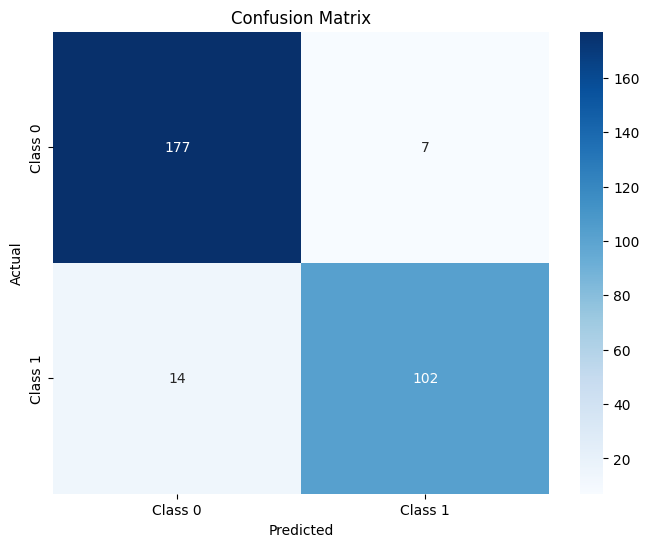

In [30]:
# confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

According to the confusion matrix, our  model is performing relatively well. It has both a high true positive (102) and true negative (177) classification rate. There seems to be a similar rate of misclassification between the false positives and false negatives, at 7/102 and 14/177. On the basis of the confusion matrix, we can theoretically calculate the precision, recall, f1 score, and accuracy, however, instead, we can use the classification report to find that information.

In [28]:
# classification report
report = classification_report(y_test, predicted, target_names=['Class 0', 'Class 1'])
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.93      0.96      0.94       184
     Class 1       0.94      0.88      0.91       116

    accuracy                           0.93       300
   macro avg       0.93      0.92      0.93       300
weighted avg       0.93      0.93      0.93       300



# Conclusion

Overall, our model significantly outperforms the baseline established by previous models, achieving an impressive average performance of 93%. For Class 0, which indicates the absence of cancer, the model exhibits both high precision and recall. This demonstrates its effectiveness in accurately identifying cases where no cancer is present. The high F1-Score further confirms that the model maintains a strong balance between precision and recall for Class 0.

For Class 1, which indicates the presence of cancer, the model shows slightly lower recall compared to Class 0 but retains relatively high precision and a strong F1-Score. This suggests that while the model is effective in diagnosing cancer, it may occasionally miss some positive cases. This trade-off between precision and recall is expected given the inherent challenges of the task.

In conclusion, the model delivers excellent performance with high overall accuracy and robust evaluations for both classes. It demonstrates effectiveness and reliability, reflecting its capability to generalize well across the test dataset.